In [1]:
import yaml
import json
from pathlib import Path
import pandas as pd
import torch

import seaborn as sns
sns.set_theme(style="darkgrid")

logdir = Path("/bigdata/cifar10/logs/decomposed")

In [2]:
import os
from datetime import datetime
from os.path import isdir

folders = os.listdir(logdir)
print(f"number of folders: {len(folders)}")

number of folders: 260


In [3]:
from datetime import datetime

dts = [datetime.fromtimestamp(int(x)) for x in folders]
print(max(dts))
print(min(dts))

2022-03-13 08:12:25
2022-03-07 19:11:43


In [4]:
paths = []
for folder in folders:
    found_decomp = False
    found_results = False
    for subfolder in os.listdir(logdir / folder):
        if 'lr' in subfolder:
            # found_decomp = True
            # break
            if (logdir / folder / subfolder / "results.json").exists():
                paths.append( logdir / folder / subfolder )
    # if not found_decomp or not found_results:
    #     folders.remove(folder)
print(len(paths))

260


In [5]:
# baseline

baseline_path = Path("/bigdata/cifar10/logs/baselines/1646668631/rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue")
baseline_model = torch.load(baseline_path / "cnn_best.pth")

In [6]:
with open(baseline_path/'results.json') as json_file:
    baseline_result = json.load(json_file)

In [7]:
baseline_result

{'best_epoch': 229,
 'best_train_acc': 0.9999333333333333,
 'best_valid_acc': 0.9216,
 'best_valid_loss': 0.005079200401902199,
 'test_acc': 0.9137,
 'test_loss': 0.005285387974977494,
 'n_param': 11173962,
 'model_name': 'rn18_18_dNone_128_adam_l0.001_g0.1_w0.0_sTrue'}

In [8]:
# def paths_to_results(paths):
#     """Returns a pandas DataFrame with results"""
#     results = []
#     for path in paths:
#         with open(path/'results.json') as json_file:
#             result = json.load(json_file)
#         with open(path / 'results_feature_metrics.json') as json_file:
#             feature_result = json.load(json_file)
#         result.update(feature_result['mean'])
#         for k,v in result.items():
#             result[k] = v[0] if type(v) == list else v
#         results.append(result)
    
#     keys = set()
#     for result in results:
#         keys = keys.union( set(result.keys()) )
    
#     blank = {k:[] for k in keys}
    
#     df = pd.DataFrame(blank) #.append(results[1], ignore_index=True)

#     for result in results:
#         df = df.append(result, ignore_index=True)
        
#     df['compression'] = df['n_param_fact']/df['n_param'][0]
#     df.compression[0] = 1.0
    
    
#     return df

In [9]:
import torch
import tensorly as tl
tl.set_backend('pytorch')
from tddl.factorizations import number_layers
from tddl.factorizations import listify_numbered_layers

def relative_error(pre_weight, dec_weight):
    with torch.no_grad():
        return tl.norm(pre_weight-dec_weight)/tl.norm(pre_weight)

def process_factorized_network(model, fact_model, layer_nrs, first_layer_nr=0):

    pretrained_numbered_layers = number_layers(model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers, 
        layer_nrs=layer_nrs
    )

    decomposed_numbered_layers_resnet18 = number_layers(fact_model)
    decomposed_conv_layers_resnet18 = listify_numbered_layers(
        decomposed_numbered_layers_resnet18, 
        layer_nrs=layer_nrs
    )

    errors_conv_resnet18 = {
        'name': [],
        'nr': [],
        'error': [],
    }

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers_resnet18):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        print(name)
        nr = pre[1]
        print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        
        errors_conv_resnet18['name'].append(name)
        errors_conv_resnet18['nr'].append(nr)
        errors_conv_resnet18['error'].append(float(error))

    df_errors = pd.DataFrame(data=errors_conv_resnet18)
    if first_layer_nr is not None:
        df_errors.name.iloc[first_layer_nr] = 'in'
    df_errors.set_index('nr', inplace=True)
    grouped_errors = df_errors.groupby(by='name')
    grouped_errors['error'].plot(legend=True, style=".-", ylabel='Relative Error', xlabel='Layer Number')

/home/jetzeschuurman/gitProjects/phd/tltorch/tltorch/factorized_tensors/core.py:145: UserWarning: Creating a subclass of FactorizedTensor TensorizedTensor with no name.
  warnings.warn(f'Creating a subclass of FactorizedTensor {cls.__name__} with no name.')


In [10]:
# calc approximation error
# store in approx_error.json, next to results.json
import yaml

for path in paths:
    print(path)
    timestamp = Path(path).parent
    config_path = logdir / timestamp / "config.yml"
    config_data = yaml.load(config_path.read_text(), Loader=yaml.Loader)
    layers = config_data['layers']

    fact_model = torch.load(path / 'model_after_fact.pth')

    pretrained_numbered_layers = number_layers(baseline_model)
    pretrained_layers = listify_numbered_layers(
        pretrained_numbered_layers,
        layer_nrs=layers,
    )

    decomposed_numbered_layers = number_layers(fact_model)
    decomposed_conv_layers = listify_numbered_layers(
        decomposed_numbered_layers,
        layer_nrs=layers,
    )

    with open(path / 'results.json') as json_file:
        result = json.load(json_file)

    with open(path / 'results_before_training.json') as json_file:
        result_before_training = json.load(json_file)

    errors_conv = {
            'name': [],
            'nr': [],
            'error': [],
            'layers': layers,
            'factorization': config_data['factorization'],
            'rank': config_data['rank'],
            'valid_acc': result['best_valid_acc'],
            'valid_acc_before_ft': result_before_training['valid_acc'],
            'n_param_fact': result['n_param_fact'],
            'test_acc': result['test_acc'],
            'lr': config_data['lr'],
            'optimizer': config_data['optimizer'],
        }

    with open(path / 'results_feature_metrics_train.json') as json_file:
        feature_result = json.load(json_file)
    train_features = feature_result['mean']
    errors_conv.update(train_features)

    # with open(path / 'results_feature_metrics_valid.json') as json_file:
    #     feature_result = json.load(json_file)
    # errors_conv.update()

    for pre, dec in zip(pretrained_layers, decomposed_conv_layers):
        
        if pre[0] != dec[0]:
            print(f'breaking: {pre[0]} != {dec[0]}')
            break
        if pre[1] != dec[1]:
            print(f'breaking: {pre[1]} != {dec[1]}')
            break
        
        name = pre[0]
        # print(name)
        nr = pre[1]
        # print(nr)

        pre_weight = pre[2].weight
        dec_weight = dec[2].weight.to_tensor()

        error = relative_error(pre_weight, dec_weight)
        # print(error)
        
        errors_conv['name'].append(name)
        errors_conv['nr'].append(nr)
        errors_conv['error'].append(float(error))

    errors_path = logdir / path / 'results_approximation_error.json'
    with open(errors_path, 'w') as f:
        json.dump(errors_conv, f)

/bigdata/cifar10/logs/decomposed/1647086226/rn18-lr-[63]-cp-0.1-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1647137535/rn18-lr-[60]-tucker-0.1-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1647138846/rn18-lr-[60]-tucker-0.25-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646683474/rn18-lr-[28]-tucker-0.1-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646682219/rn18-lr-[28]-tucker-0.9-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646684848/rn18-lr-[63]-tucker-0.5-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1647152038/rn18-lr-[44]-tucker-0.1-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1646682858/rn18-lr-[28]-cp-0.1-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/decomposed/1647090698/rn18-lr-[15]-tucker-0.25-dTrue-iNone_bn_128_sgd_l1e-05_g0.0_sTrue
/bigdata/cifar10/logs/dec

In [10]:
results = []
for path in paths:
    with open(path / 'results_approximation_error.json') as json_file:
        result = json.load(json_file)
    # print(result)
    for k,v in result.items():
        result[k] = v[0] if type(v) == list else v
    results.append(result)

In [11]:
df = pd.DataFrame(results)
print(len(df))
df.head()


260


,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
0,conv2,63,0.311843,63,cp,0.1,0.9210,0.9216,9050765,0.9143,0.00001,adam,12.214946,429.339663,2048.0,0.028521,0.005964
1,conv1,60,0.337100,60,tucker,0.1,0.9206,0.9216,9051469,0.9137,0.00001,adam,75.989307,2603.942812,2048.0,0.029340,0.037104
2,conv1,60,0.272814,60,tucker,0.25,0.9210,0.9216,9402829,0.9148,0.00001,adam,47.516211,2603.942812,2048.0,0.018346,0.023201
3,conv1,28,0.823151,28,tucker,0.1,0.9018,0.8690,11041517,0.8974,0.00001,adam,388.085709,815.280181,8192.0,0.476089,0.047374
4,conv1,28,0.305965,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,0.00001,adam,105.363881,815.280181,8192.0,0.129281,0.012862


In [12]:
df['rank'] = df['rank'].astype(float, copy=False)
# df['rank'].apply(float)
df['rank'].unique()
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df['fact_layers'] = df['factorization'] + '-' + df['layers'].apply(str)
df['layers_fact'] = df['layers'].apply(str) + '-' + df['factorization'] 
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact
0,conv2,63,0.311843,63,cp,0.10,0.9210,0.9216,9050765,0.9143,0.00001,adam,12.214946,429.339663,2048.0,0.028521,0.005964,cp-0.1,cp-63,63-cp
1,conv1,60,0.337100,60,tucker,0.10,0.9206,0.9216,9051469,0.9137,0.00001,adam,75.989307,2603.942812,2048.0,0.029340,0.037104,tucker-0.1,tucker-60,60-tucker
2,conv1,60,0.272814,60,tucker,0.25,0.9210,0.9216,9402829,0.9148,0.00001,adam,47.516211,2603.942812,2048.0,0.018346,0.023201,tucker-0.25,tucker-60,60-tucker
3,conv1,28,0.823151,28,tucker,0.10,0.9018,0.8690,11041517,0.8974,0.00001,adam,388.085709,815.280181,8192.0,0.476089,0.047374,tucker-0.1,tucker-28,28-tucker
4,conv1,28,0.305965,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,0.00001,adam,105.363881,815.280181,8192.0,0.129281,0.012862,tucker-0.9,tucker-28,28-tucker


In [13]:
df = df.astype({
    'layers':"category",
    'fact_layers':"category",
    'layers_fact':"category",
})

## Approximation error on the weights

In [14]:
df_rank = df.set_index('rank', inplace=False)

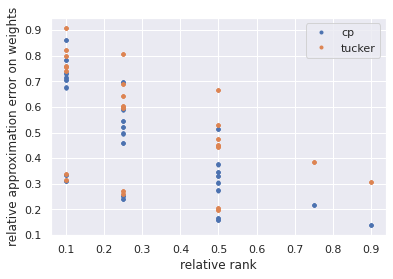

In [15]:
grouped_df = df_rank.groupby('factorization')
ax = grouped_df['error'].plot(legend=True, style=".", ylabel='relative approximation error on weights', xlabel='relative rank')

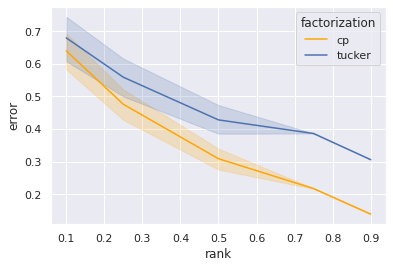

In [16]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)
# Plot the responses for different events and regions
ax = sns.lineplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)

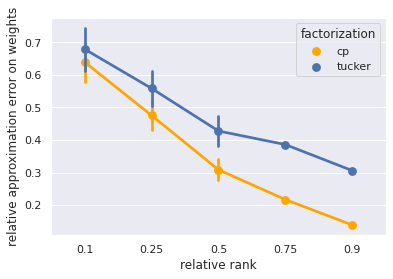

In [17]:
ax = sns.pointplot(x="rank", y="error",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.set(xlabel='relative rank', ylabel='relative approximation error on weights')

[(0.865, 0.925)]

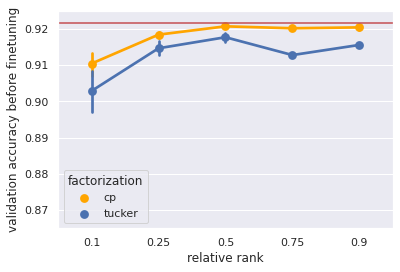

In [18]:
ax = sns.pointplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative rank', ylabel='validation accuracy before finetuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

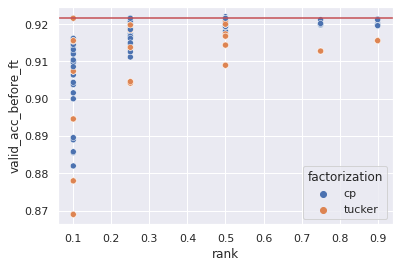

In [19]:
ax = sns.scatterplot(x="rank", y="valid_acc_before_ft",
    hue="factorization",
    # style="factorization",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

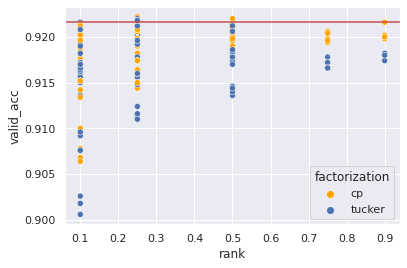

In [20]:
ax = sns.scatterplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['best_valid_acc'], color='r')

[(0.865, 0.925)]

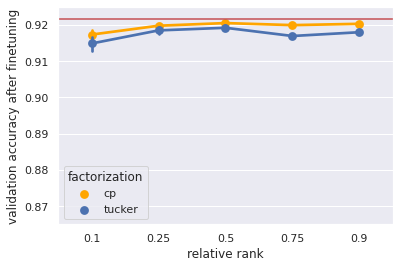

In [21]:
ax = sns.pointplot(x="rank", y="valid_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='validation accuracy after finetuning')
ax.set(ylim=(0.865, 0.925))

[Text(0.5, 0, 'relative rank'), Text(0, 0.5, 'test accuracy after finetuning')]

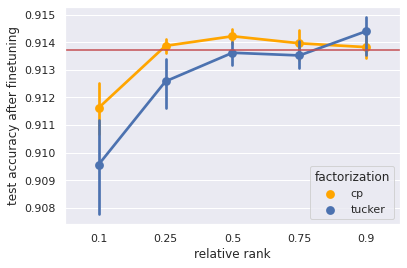

In [22]:
ax = sns.pointplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='relative rank', ylabel='test accuracy after finetuning')
# ax.set(ylim=(0.865, 0.925))

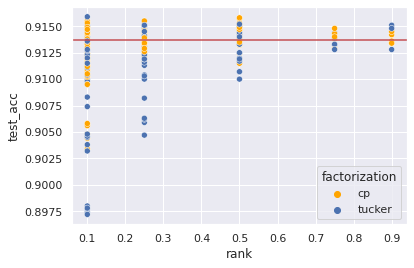

In [23]:
ax = sns.scatterplot(x="rank", y="test_acc",
    hue="factorization",
    # style="rank",
    data=df,
    palette=['orange', 'b'],
)
ax = ax.axhline(baseline_result['test_acc'], color='r')

In [24]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['rank'].plot(legend=True, style=".-", ylabel='relative rank', xlabel='relative approximation error')

In [25]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

[(0.865, 0.925)]

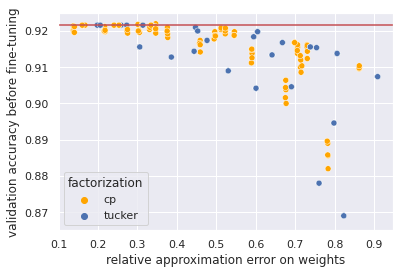

In [26]:
ax = sns.scatterplot(
    x="error", y="valid_acc_before_ft", 
    hue="factorization", 
    # style="factorization",
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy before fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

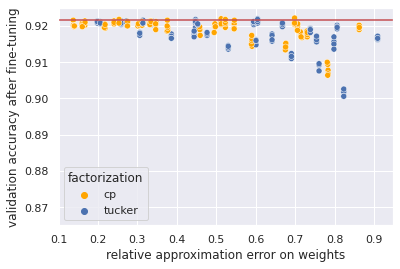

In [27]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

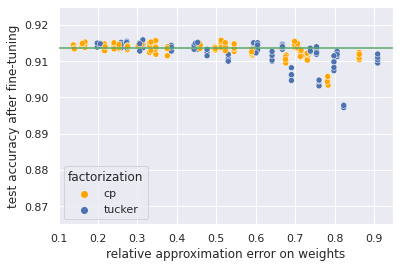

In [28]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

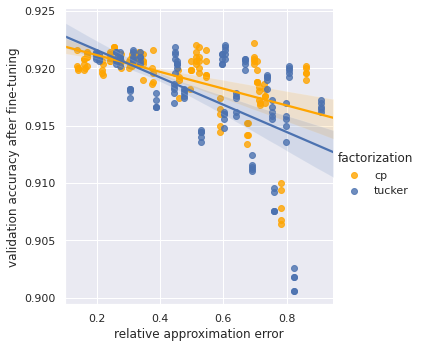

In [29]:
g = sns.lmplot(x="error", y="valid_acc",
    hue="factorization", data=df,
    # y_jitter=.02, 
    # logistic=True, 
    # style="rank",
    truncate=False, palette=['orange', 'b'], 
)
g = g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')


In [30]:
df['fact_rank'] = df['factorization'] + '-' + df['rank'].apply(str)
df.head()

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact
0,conv2,63,0.311843,63,cp,0.10,0.9210,0.9216,9050765,0.9143,0.00001,adam,12.214946,429.339663,2048.0,0.028521,0.005964,cp-0.1,cp-63,63-cp
1,conv1,60,0.337100,60,tucker,0.10,0.9206,0.9216,9051469,0.9137,0.00001,adam,75.989307,2603.942812,2048.0,0.029340,0.037104,tucker-0.1,tucker-60,60-tucker
2,conv1,60,0.272814,60,tucker,0.25,0.9210,0.9216,9402829,0.9148,0.00001,adam,47.516211,2603.942812,2048.0,0.018346,0.023201,tucker-0.25,tucker-60,60-tucker
3,conv1,28,0.823151,28,tucker,0.10,0.9018,0.8690,11041517,0.8974,0.00001,adam,388.085709,815.280181,8192.0,0.476089,0.047374,tucker-0.1,tucker-28,28-tucker
4,conv1,28,0.305965,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,0.00001,adam,105.363881,815.280181,8192.0,0.129281,0.012862,tucker-0.9,tucker-28,28-tucker


In [31]:
# g = sns.lmplot(x="error", y="test_acc", 
#    hue="fact_rank", 
#    data=df,
#    truncate=False, 
#    # palette=['orange','b'],
# )
# g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')
# g.set(ylim=(0.935, 0.945))

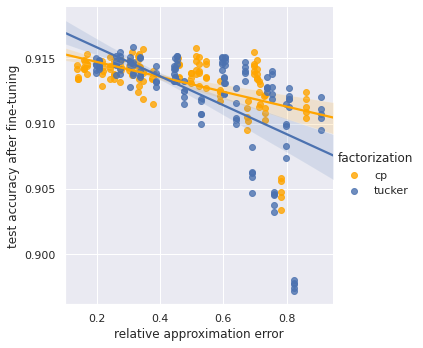

In [32]:
ax = sns.lmplot(x="error", y="test_acc", 
   hue="factorization", 
   data=df,
   # logistic=True,
   truncate=False, 
   palette=['orange','b'],
)
ax.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')


In [33]:
# df = pd.DataFrame(results)
# df.set_index('error', inplace=True)
# grouped_df = df.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

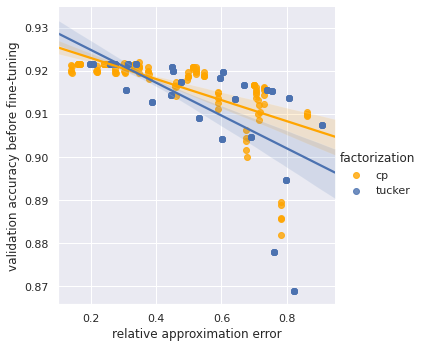

In [34]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

In [35]:
df_layers = pd.DataFrame(results)
df_layers['rank'] = df_layers['rank'].astype(float, copy=False)
df_layers = df_layers.loc[df_layers['rank'] == 0.5]
df_layers

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm
5,conv2,63,0.198279,63,tucker,0.5,0.9210,0.9216,9997024,0.9145,0.00001,adam,6.153332,429.339663,2048.0,0.014415,0.003005
9,conv2,15,0.304725,15,cp,0.5,0.9206,0.9198,11155728,0.9140,0.00001,adam,47.736296,545.957711,16384.0,0.087451,0.002914
12,conv2,38,0.346829,38,cp,0.5,0.9212,0.9208,10879449,0.9119,0.00001,adam,54.038538,420.262521,4096.0,0.128686,0.013193
22,conv2,15,0.301261,15,cp,0.5,0.9200,0.9218,11155728,0.9141,0.00001,adam,47.295244,545.957711,16384.0,0.086648,0.002887
26,conv1,28,0.375088,28,cp,0.5,0.9186,0.9198,11100409,0.9134,0.00001,adam,110.821921,815.280181,8192.0,0.135994,0.013528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,conv2,63,0.160493,63,cp,0.5,0.9200,0.9216,9995161,0.9147,0.00001,adam,4.984808,429.339663,2048.0,0.011677,0.002434
251,conv1,60,0.167152,60,cp,0.5,0.9210,0.9216,9995161,0.9153,0.00001,adam,20.135873,2603.942812,2048.0,0.007780,0.009832
255,conv1,44,0.447319,44,tucker,0.5,0.9212,0.9210,10879741,0.9150,0.00001,adam,135.603151,726.060440,4096.0,0.186951,0.033106
256,conv2,63,0.160246,63,cp,0.5,0.9198,0.9216,9995161,0.9149,0.00001,adam,4.885679,429.339663,2048.0,0.011455,0.002386


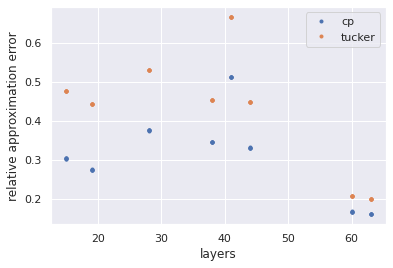

In [36]:
df_layers_idx = df_layers.set_index('layers', inplace=False)
grouped_df_layers = df_layers_idx.groupby('factorization')
ax = grouped_df_layers['error'].plot(legend=True, style=".", ylabel='relative approximation error')

In [37]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('layers', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['error'].plot(legend=True, style=".-", ylabel='relative approximation error')

# ax = grouped_df_layers['valid_acc'].plot(legend=True, style=".", ylabel='validation accuracy after fine-tuning', xlabel='relative approximation error')

In [38]:
# df_layers = pd.DataFrame(results_layers)
# df_layers.set_index('error', inplace=True)
# grouped_df = df_layers.groupby('factorization')
# grouped_df['valid_acc_before_ft'].plot(legend=True, style=".", ylabel='validation accuracy before fine-tuning', xlabel='relative approximation error')

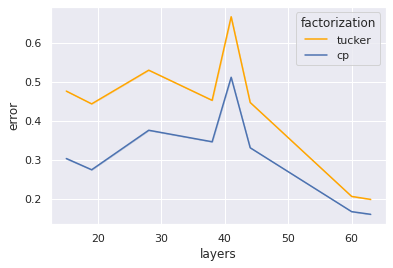

In [39]:
# df = pd.DataFrame(results)
# df['rank'] = df['rank'].astype(float, copy=False)

# Plot the responses for different events and regions
ax = sns.lineplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             )

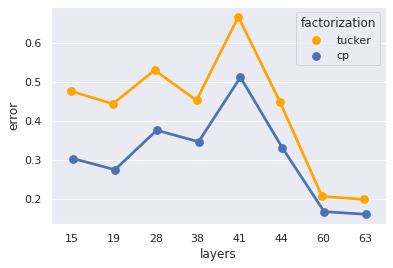

In [40]:
ax = sns.pointplot(x="layers", y="error",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True
             )

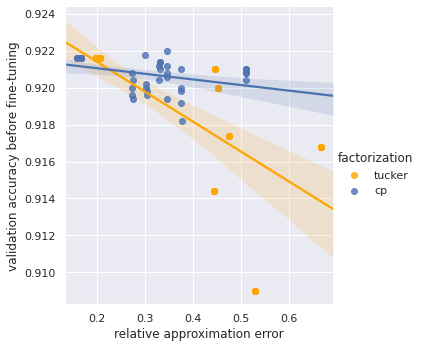

In [41]:
g = sns.lmplot(x="error", y="valid_acc_before_ft", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy before fine-tuning')

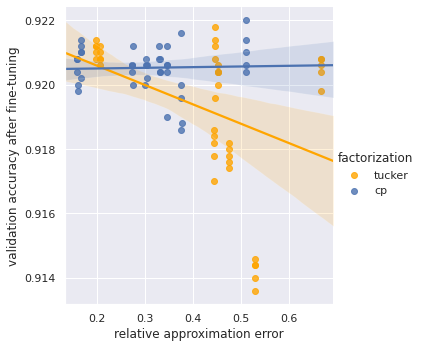

In [42]:
g = sns.lmplot(x="error", y="valid_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='validation accuracy after fine-tuning')

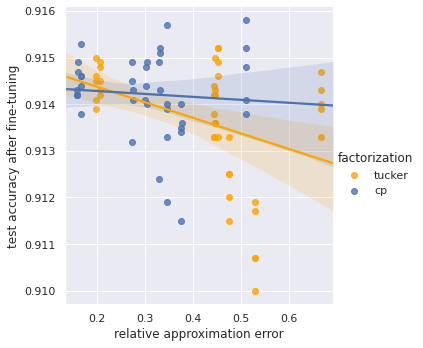

In [43]:
g = sns.lmplot(x="error", y="test_acc", hue="factorization", data=df_layers,
            #    y_jitter=.02, 
               # logistic=True, 
               truncate=False, 
               palette=['orange', 'b'], 
               )
g.set(xlabel='relative approximation error', ylabel='test accuracy after fine-tuning')

[Text(0.5, 0, 'layer number'),
 Text(0, 0.5, 'validation accuracy before fine-tuning')]

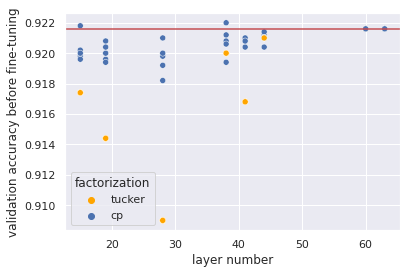

In [44]:
ax = sns.scatterplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    # dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
# ax.set(ylim=(0.908, 0.9220))

[(0.908, 0.922)]

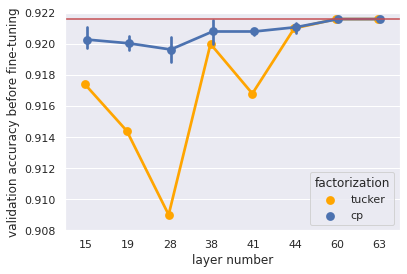

In [45]:
ax = sns.pointplot(x="layers", y="valid_acc_before_ft",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy before fine-tuning')
ax.set(ylim=(0.908, 0.9220))

[(0.908, 0.922)]

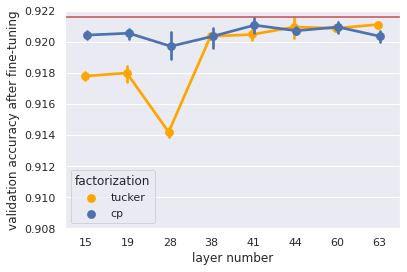

In [46]:
ax = sns.pointplot(x="layers", y="valid_acc",
    hue="factorization", 
    # style="rank",
    data=df_layers,
    palette=['orange', 'b'],
    dodge=True,
    )
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(xlabel='layer number', ylabel='validation accuracy after fine-tuning')
ax.set(ylim=(0.908, 0.9220))


[Text(0.5, 0, 'layer number'), Text(0, 0.5, 'test accuracy after fine-tuning')]

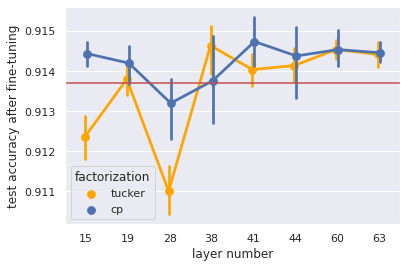

In [47]:
ax = sns.pointplot(x="layers", y="test_acc",
             hue="factorization", 
            #  style="rank",
             data=df_layers,
             palette=['orange', 'b'],
             dodge=True)
ax.axhline(baseline_result['test_acc'], color='r')
ax.set(xlabel='layer number', ylabel='test accuracy after fine-tuning')

In [48]:
df.factorization.isna()

0      False
1      False
2      False
3      False
4      False
       ...  
255    False
256    False
257    False
258    False
259    False
Name: factorization, Length: 260, dtype: bool

In [49]:
df[df.error.isnull()]

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,lr,optimizer,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact


In [50]:
df_layer_rank = df.groupby(['factorization','layers','rank'])
df_std = df_layer_rank[['valid_acc','test_acc']].std()

print(df_std.to_latex())

# df.to_json("/home/jetzeschuurman/gitProjects/phd/tddl/artifacts/f_mnist/std_adam.json")

\begin{tabular}{lllrr}
\toprule
       &    &      &  valid\_acc &  test\_acc \\
factorization & layers & rank &            &           \\
\midrule
cp & 15 & 0.10 &   0.000687 &  0.000886 \\
       &    & 0.25 &   0.000876 &  0.000358 \\
       &    & 0.50 &   0.000329 &  0.000404 \\
       &    & 0.75 &        NaN &       NaN \\
       &    & 0.90 &        NaN &       NaN \\
       & 19 & 0.10 &   0.000767 &  0.000858 \\
       &    & 0.25 &   0.000890 &  0.000658 \\
       &    & 0.50 &   0.000434 &  0.000632 \\
       &    & 0.75 &        NaN &       NaN \\
       &    & 0.90 &        NaN &       NaN \\
       & 28 & 0.10 &   0.001579 &  0.000970 \\
       &    & 0.25 &   0.001178 &  0.000597 \\
       &    & 0.50 &   0.001197 &  0.000977 \\
       &    & 0.75 &   0.000518 &  0.000702 \\
       &    & 0.90 &   0.000729 &  0.000502 \\
       & 38 & 0.10 &   0.000616 &  0.000823 \\
       &    & 0.25 &   0.001033 &  0.000862 \\
       &    & 0.50 &   0.000817 &  0.001370 \\
       &  

## Analysis on the features space

### Relative Norm

[(0.865, 0.925)]

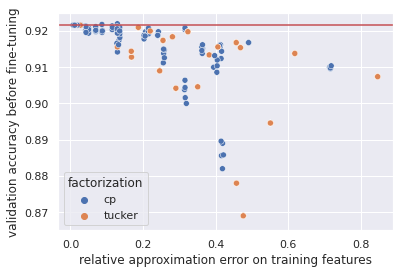

In [51]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
     hue="factorization", 
    # style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

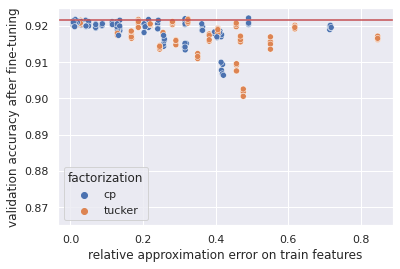

In [52]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
     hue="factorization", 
    # style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

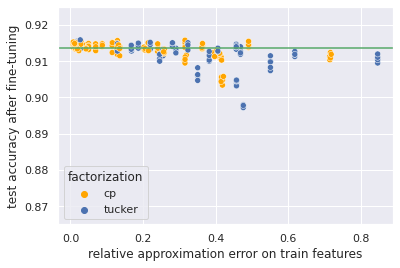

In [53]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

### Scaled Norm

[(0.865, 0.925)]

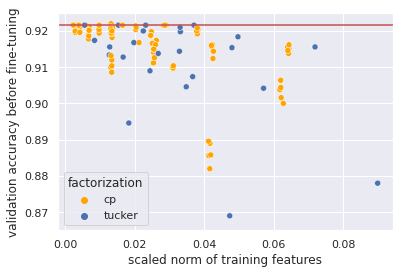

In [54]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

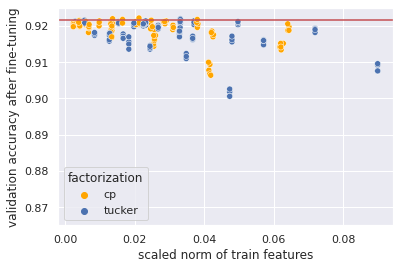

In [55]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

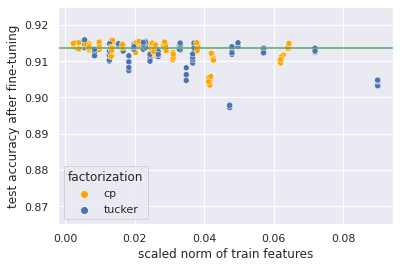

In [56]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

### Norm of Difference

[(0.865, 0.925)]

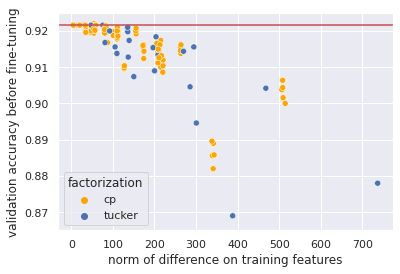

In [57]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="factorization", 
    data=df,
    palette=['orange', 'b'], 
)
ax.set(
    xlabel='norm of difference on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

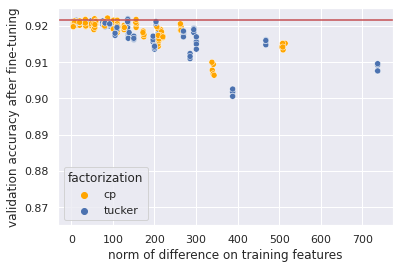

In [58]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'], 
)
ax.set(xlabel='norm of difference on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

[(0.865, 0.925)]

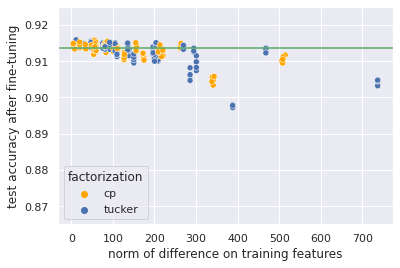

In [59]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

In [60]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

[(0.865, 0.925)]

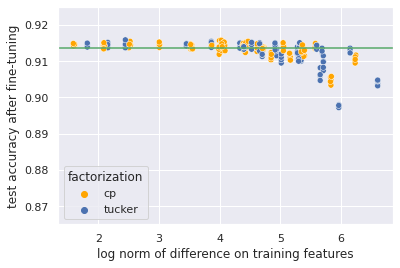

In [61]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='log norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))

In [62]:
df['log_test_acc'] = np.log(df.test_acc)

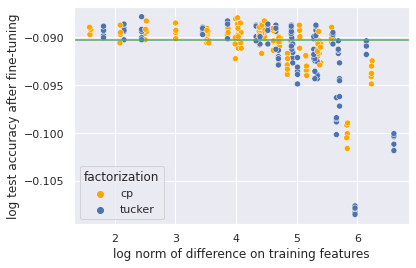

In [63]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="factorization", data=df,
    palette=['orange', 'b'],
)
ax.set(xlabel='log norm of difference on training features', ylabel='log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))

# Per Layer

[(0.865, 0.925)]

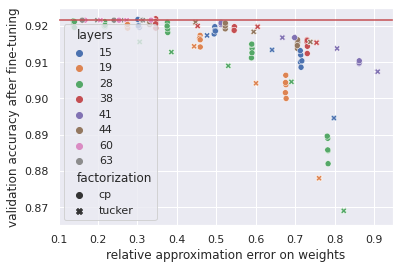

In [64]:
ax = sns.scatterplot(x="error", y="valid_acc_before_ft",
    hue="layers",
    style="factorization",
    data=df,
    # palette=['orange', 'black', 'red', 'green', 'blue', 'yellow'], #['orange','b']
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))

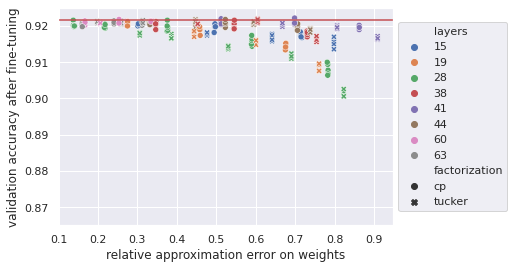

In [65]:
ax = sns.scatterplot(x="error", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
    
)
ax.set(xlabel='relative approximation error on weights', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

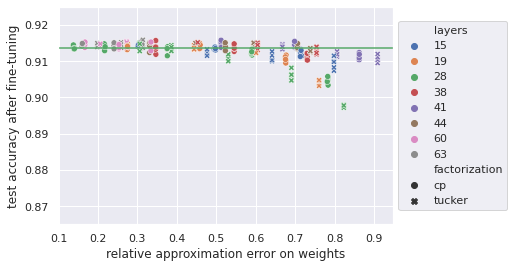

In [66]:
ax = sns.scatterplot(x="error", y="test_acc",
    hue="layers",
    style="factorization", 
    data=df,
    # palette=['orange', 'b'],
)
ax.set(xlabel='relative approximation error on weights', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Feature Space

### Relative Norm

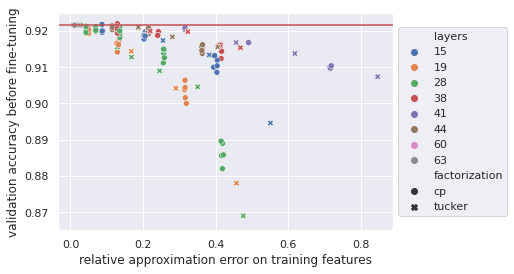

In [67]:
ax = sns.scatterplot(
    x="relative_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='relative approximation error on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

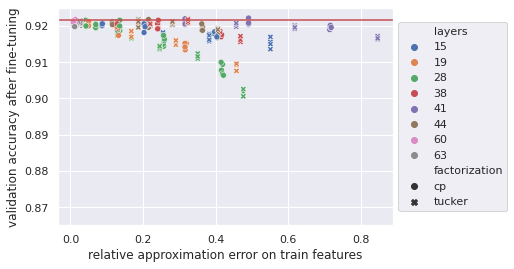

In [68]:
ax = sns.scatterplot(x="relative_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

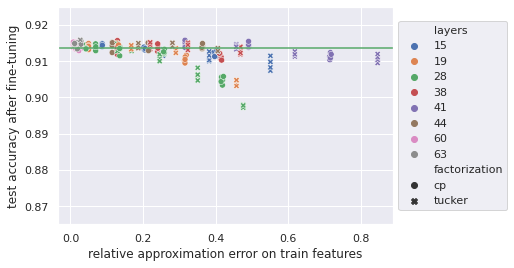

In [69]:
ax = sns.scatterplot(x="relative_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='relative approximation error on train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Scaled Norm

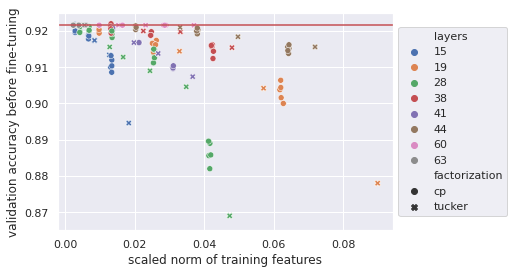

In [70]:
ax = sns.scatterplot(
    x="scaled_norm", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='scaled norm of training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

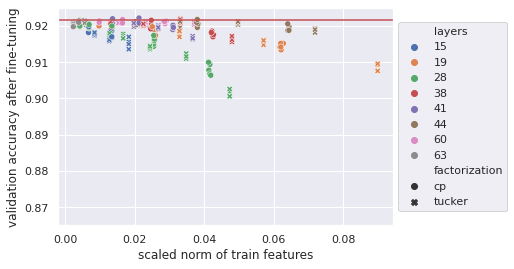

In [71]:
ax = sns.scatterplot(x="scaled_norm", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

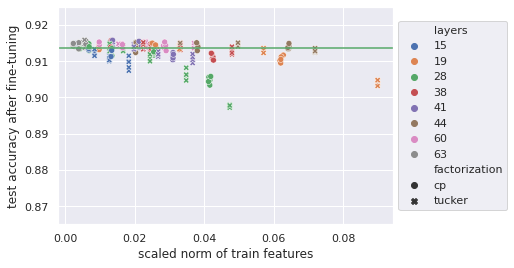

In [72]:
ax = sns.scatterplot(x="scaled_norm", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='scaled norm of train features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Norm of Difference

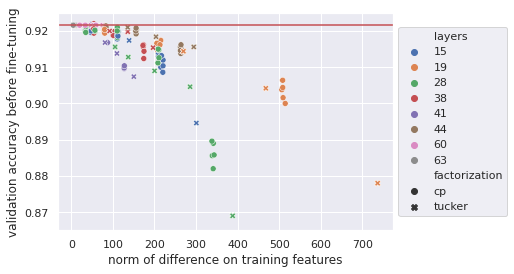

In [73]:
ax = sns.scatterplot(
    x="norm_diff", y="valid_acc_before_ft", 
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(
    xlabel='norm of difference on training features', 
    ylabel='validation accuracy before fine-tuning'
)
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

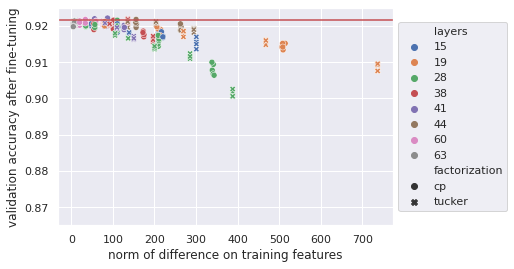

In [74]:
ax = sns.scatterplot(x="norm_diff", y="valid_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='norm of difference on training features', ylabel='validation accuracy after fine-tuning')
ax.axhline(baseline_result['best_valid_acc'], color='r')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

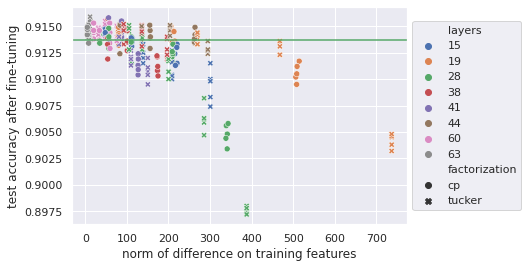

In [75]:
ax = sns.scatterplot(x="norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [76]:
import numpy as np
df['log_norm_diff'] = np.log(df.norm_diff)

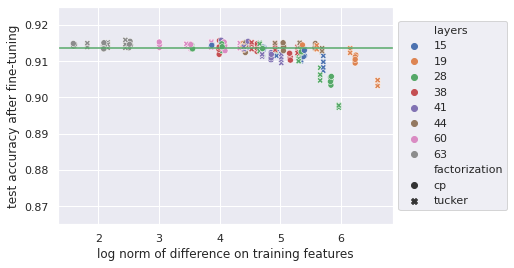

In [77]:
ax = sns.scatterplot(x="log_norm_diff", y="test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='log norm of difference on training features', ylabel='test accuracy after fine-tuning')
ax.axhline(baseline_result['test_acc'], color='g')
ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [78]:
df['log_test_acc'] = np.log(df.test_acc)

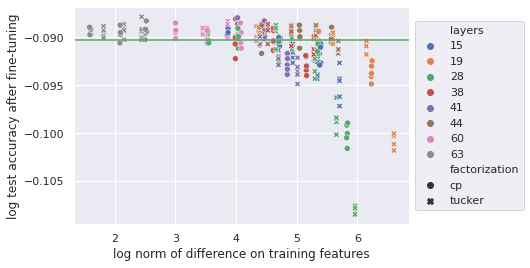

In [79]:
ax = sns.scatterplot(x="log_norm_diff", y="log_test_acc",
    hue="layers", 
    style="factorization",
    data=df,
    # palette=['orange', 'b'], 
)
ax.set(xlabel='log norm of difference on training features', ylabel='log test accuracy after fine-tuning')
ax.axhline(np.log(baseline_result['test_acc']), color='g')
# ax.set(ylim=(0.865, 0.925))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

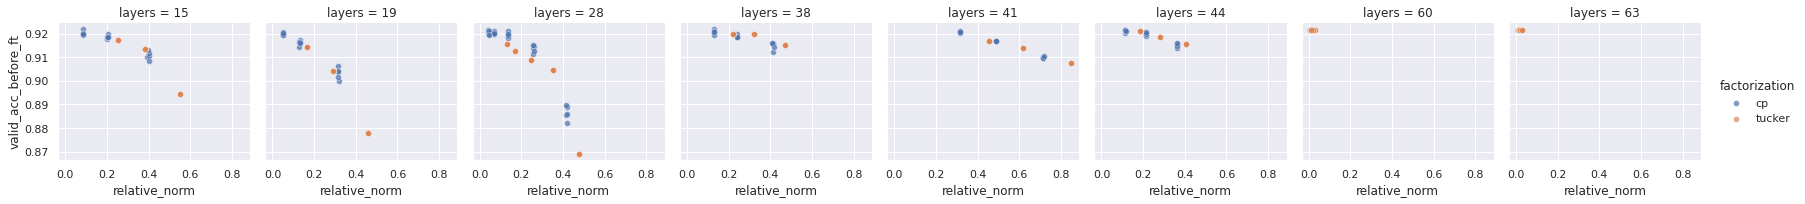

In [80]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc_before_ft", alpha=.7)
g.add_legend()

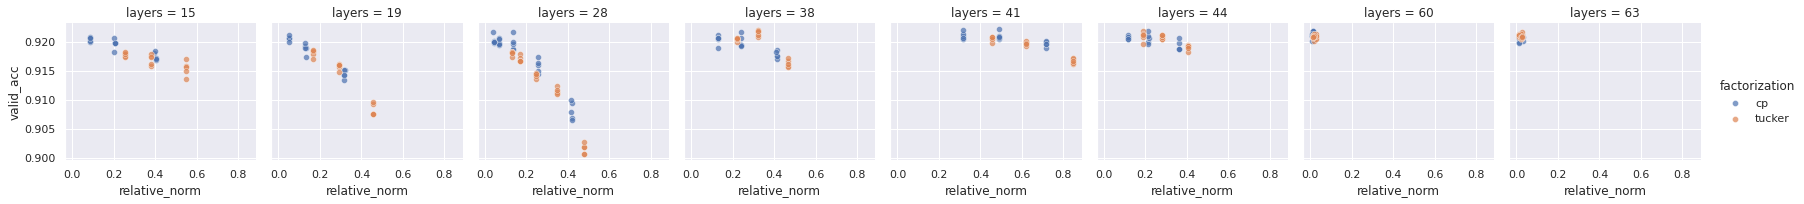

In [81]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "valid_acc", alpha=.7)
g.add_legend()

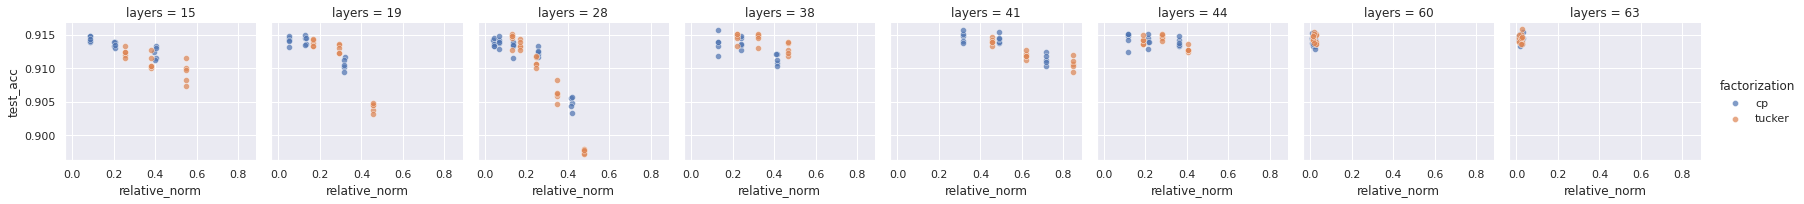

In [82]:
g = sns.FacetGrid(df, col="layers", hue="factorization")
g.map(sns.scatterplot, "relative_norm", "test_acc", alpha=.7)
g.add_legend()
# g.axhline(np.log(baseline_result['test_acc']), color='g')

In [83]:
replacements = {
    'valid_acc_before_ft': "Validation accuracy before fine-tuning", 
    'valid_acc': "Validation accuracy after fine-tuning",
    'test_acc': "Test accuracy after fine-tuning", 
    'error': 'Relative norm on weights',
    'relative_norm': 'Relative norm on training features',
    'scaled_norm': 'Scaled norm on training features',
    'norm_diff': 'Norm of the difference between training features',
    'log_norm_diff': 'Log norm of the difference between training features',
}

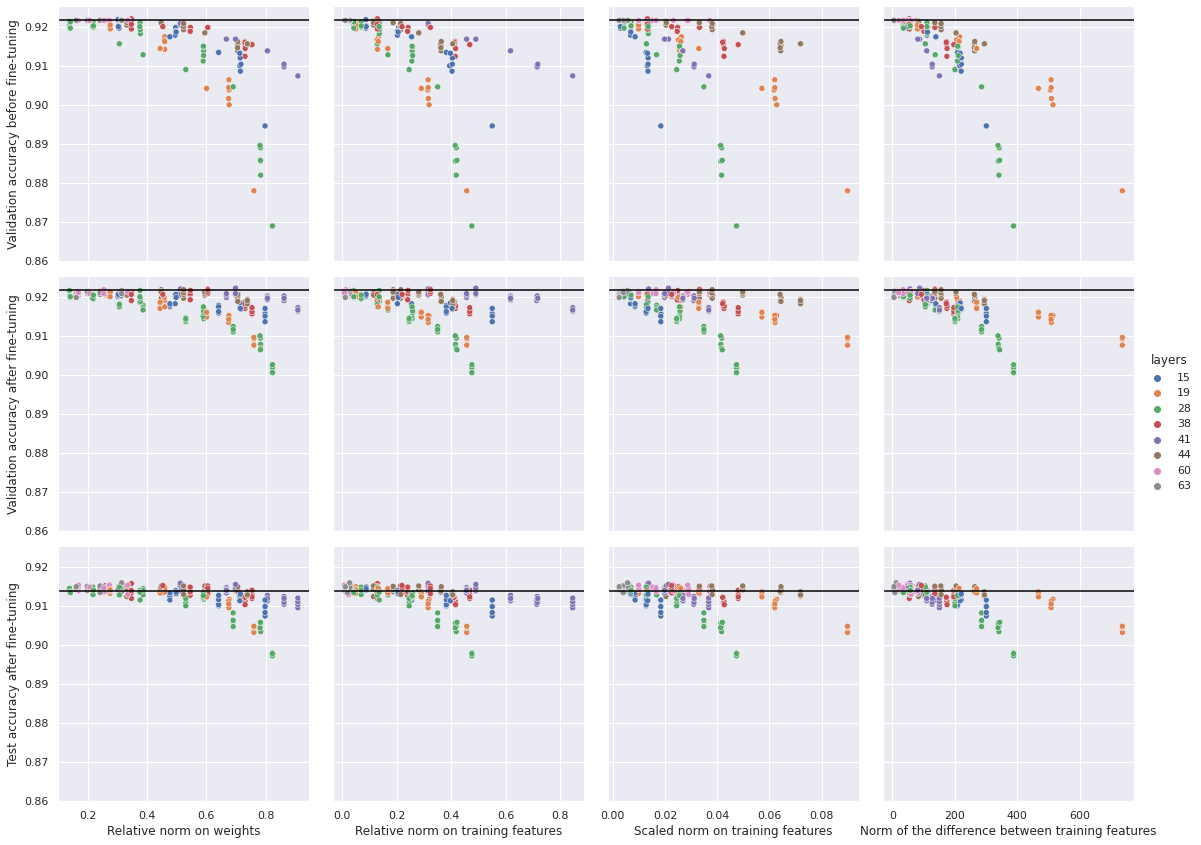

In [84]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])



/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f240c770460> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


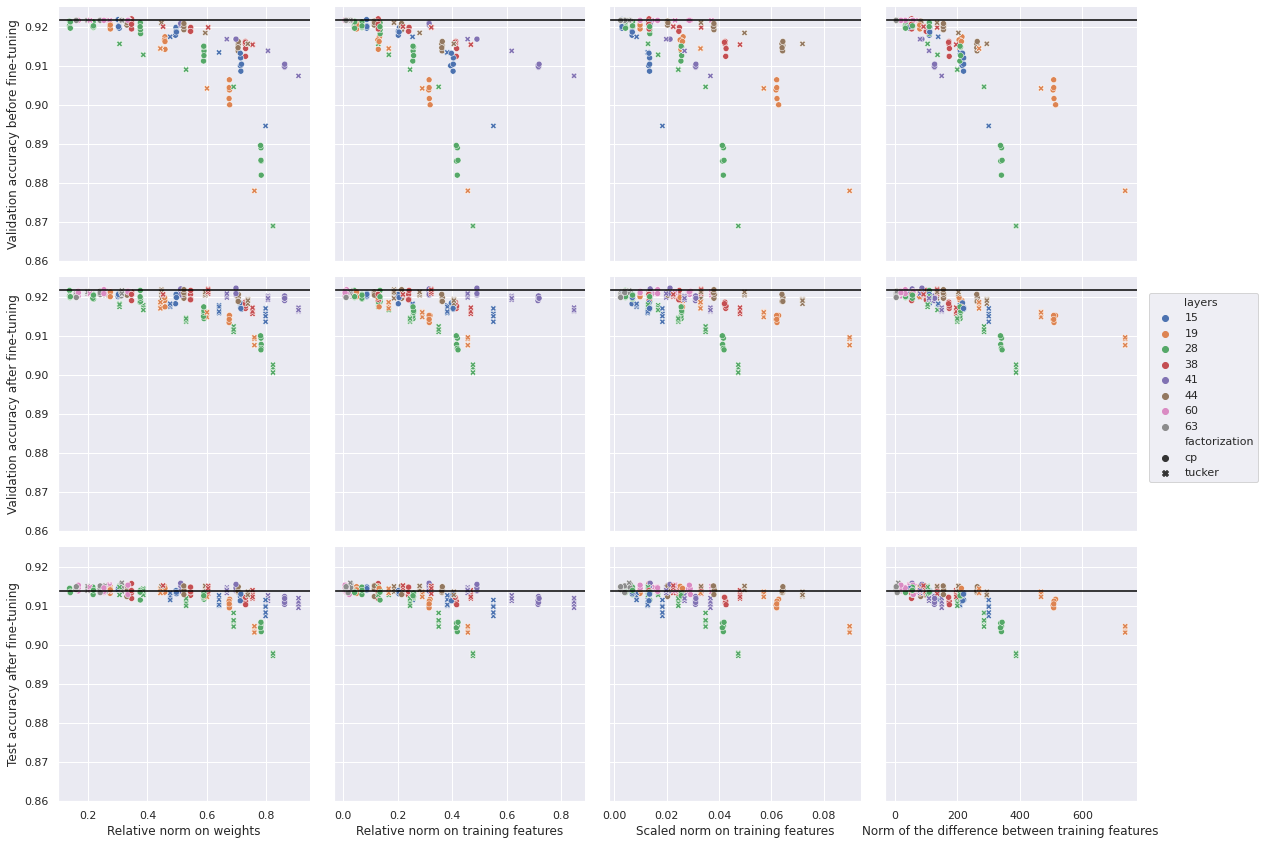

In [85]:
from matplotlib import pyplot as plt 

g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
g.set(ylim=(0.86,0.925))
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/seaborn/axisgrid.py:156: UserWarning: The handle <matplotlib.patches.Patch object at 0x7f24f4f900a0> has a label of '_nolegend_' which cannot be automatically added to the legend.
  figlegend = self._figure.legend(handles, labels, **kwargs)


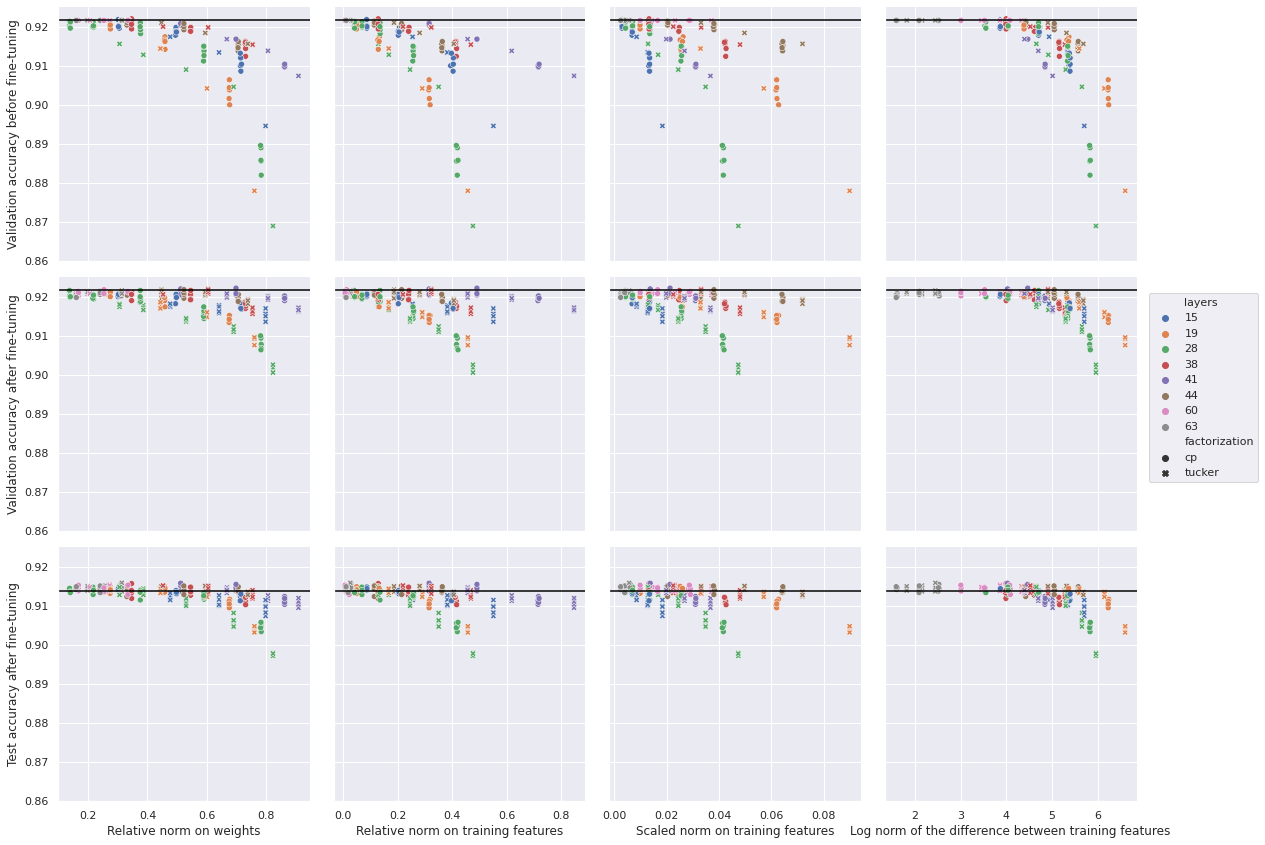

In [123]:
from matplotlib import pyplot as plt 

g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"log_norm_diff"],
    height=4,
)
g.map(lambda x, y, **kwargs: sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')) # color=".3")
g.set(ylim=(0.86,0.925))
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])
plt.legend(
    bbox_to_anchor=(1.05, 1,1,1),
    loc='upper left', borderaxespad=0.
    # loc='right',
    # bbox_to_anchor=(1.1, 0.5, 0, 0),
)
# g.fig.get_children()[-1].set_bbox_to_anchor((1.1, 0.5, 0, 0))

# g.savefig("../../plots/cifar10/rn18/scatter_errors_performances_layers_factorizations")

In [122]:
!pwd

/home/jetzeschuurman/gitProjects/phd/tddl/notebooks/results


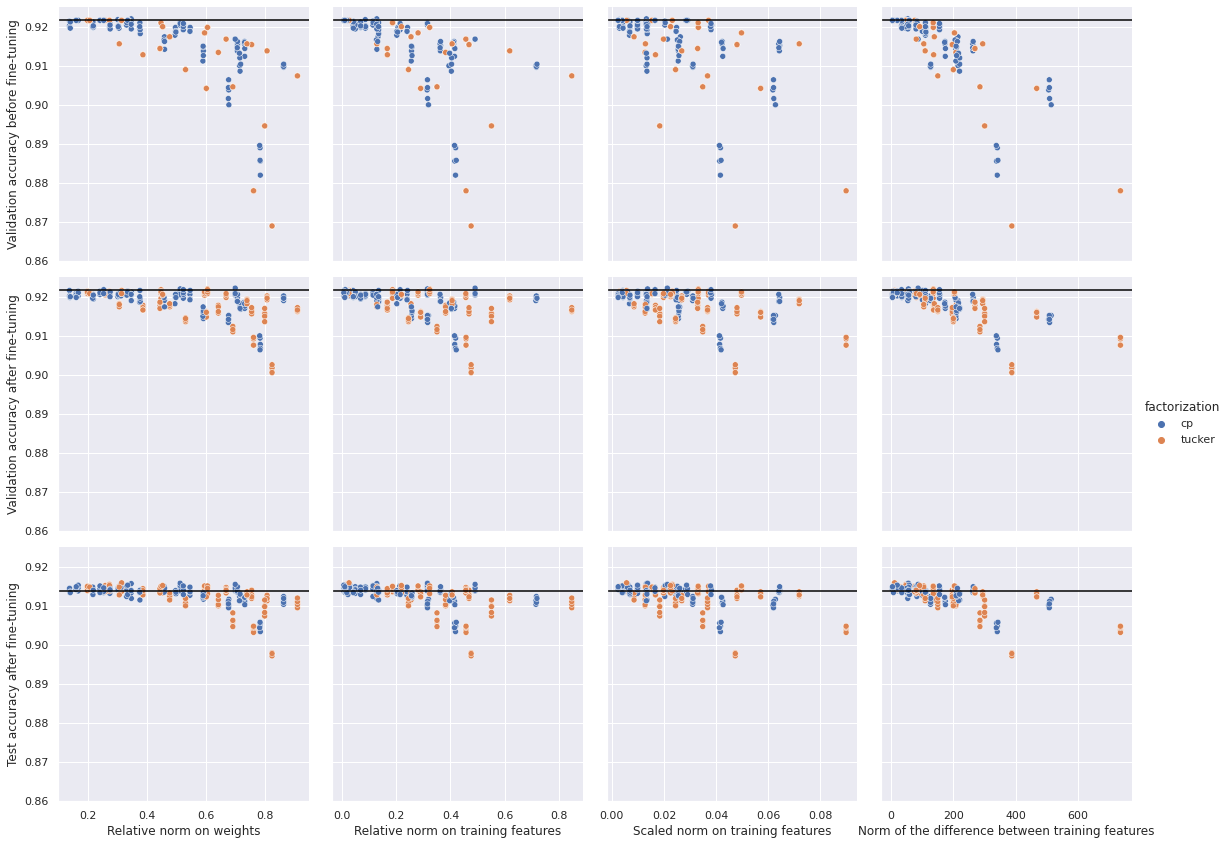

In [87]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="factorization",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

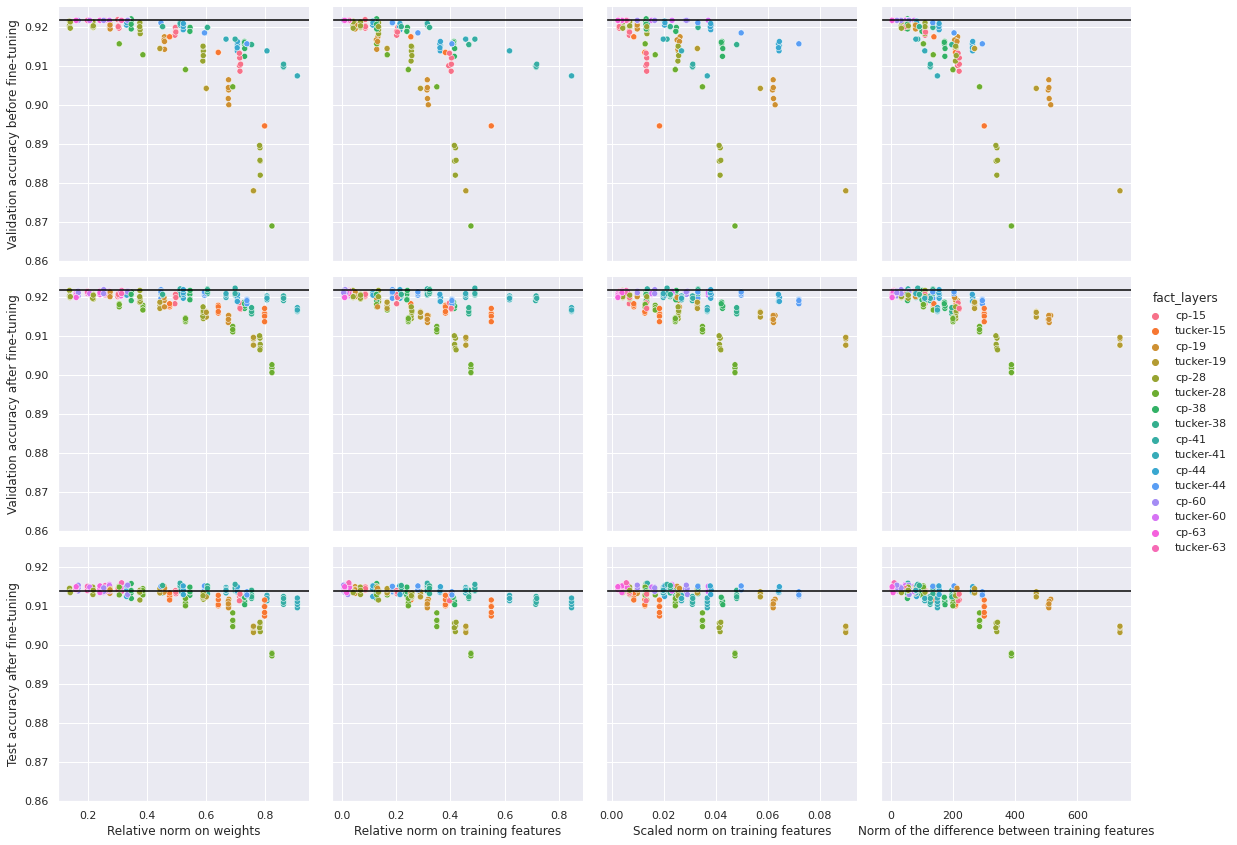

In [88]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff"],
    hue="fact_layers",
    height=4,
    hue_order=[
        'cp-15','tucker-15','cp-19','tucker-19','cp-28','tucker-28','cp-38','tucker-38',
        'cp-41','tucker-41','cp-44','tucker-44','cp-60','tucker-60','cp-63','tucker-63',
    ]
    # palette=['b','orange']
    # style="factorization",
) #, height=4)
g.map(sns.scatterplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(4):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

In [89]:
df

,name,nr,error,layers,factorization,rank,valid_acc,valid_acc_before_ft,n_param_fact,test_acc,...,norm_diff,norm_b,n_b,relative_norm,scaled_norm,fact_rank,fact_layers,layers_fact,log_norm_diff,log_test_acc
0,conv2,63,0.311843,63,cp,0.10,0.9210,0.9216,9050765,0.9143,...,12.214946,429.339663,2048.0,0.028521,0.005964,cp-0.1,cp-63,63-cp,2.502660,-0.089597
1,conv1,60,0.337100,60,tucker,0.10,0.9206,0.9216,9051469,0.9137,...,75.989307,2603.942812,2048.0,0.029340,0.037104,tucker-0.1,tucker-60,60-tucker,4.330593,-0.090253
2,conv1,60,0.272814,60,tucker,0.25,0.9210,0.9216,9402829,0.9148,...,47.516211,2603.942812,2048.0,0.018346,0.023201,tucker-0.25,tucker-60,60-tucker,3.861071,-0.089050
3,conv1,28,0.823151,28,tucker,0.10,0.9018,0.8690,11041517,0.8974,...,388.085709,815.280181,8192.0,0.476089,0.047374,tucker-0.1,tucker-28,28-tucker,5.961226,-0.108254
4,conv1,28,0.305965,28,tucker,0.90,0.9182,0.9156,11159148,0.9145,...,105.363881,815.280181,8192.0,0.129281,0.012862,tucker-0.9,tucker-28,28-tucker,4.657420,-0.089378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,conv1,44,0.447319,44,tucker,0.50,0.9212,0.9210,10879741,0.9150,...,135.603151,726.060440,4096.0,0.186951,0.033106,tucker-0.5,tucker-44,44-tucker,4.909733,-0.088831
256,conv2,63,0.160246,63,cp,0.50,0.9198,0.9216,9995161,0.9149,...,4.885679,429.339663,2048.0,0.011455,0.002386,cp-0.5,cp-63,63-cp,1.586308,-0.088941
257,conv2,38,0.452808,38,tucker,0.50,0.9206,0.9200,10879741,0.9152,...,92.270423,420.262521,4096.0,0.219677,0.022527,tucker-0.5,tucker-38,38-tucker,4.524724,-0.088613
258,conv2,15,0.798234,15,tucker,0.10,0.9170,0.8946,11140672,0.9115,...,300.793008,545.957711,16384.0,0.550880,0.018359,tucker-0.1,tucker-15,15-tucker,5.706422,-0.092664


# Kendals tau

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kendalltau.html

In [130]:
from scipy.stats import kendalltau

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

# TODO: make multilevel columns 
# https://stackoverflow.com/questions/21443963/pandas-multilevel-column-names

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_kt = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = kendalltau(df[error], df[metric])
        df_kt[error][metric] = corr

In [131]:
from scipy.stats import kendalltau

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

# TODO: make multilevel columns 
# https://stackoverflow.com/questions/21443963/pandas-multilevel-column-names

# errors = ['error', 'relative_norm','scaled_norm','norm_diff']
# metrics = ['valid_acc_before_ft','valid_acc','test_acc']

# columns = []
# for error in errors:
#     columns.append(f'{error}_tau')
#     columns.append(f'{error}_p')

# df_kt = pd.DataFrame(index=metrics, columns=errors)

# for error in errors:
#     for metric in metrics:
#         corr, p = kendalltau(df[error], df[metric])
#         df_kt[f'{error}_tau'][metric] = corr
#         df_kt[f'{error}_p'][metric] = p

In [132]:
neat_table_indices = {
    'valid_acc_before_ft': "Val. before f.t.",
    'valid_acc': "Val. after f.t.",
    'test_acc': "Test after f.t.",
}
neat_table_columns = {
    'error': "Relative-weights",
    'relative_norm': "Relative-features",
    'scaled_norm': "Scaled-features",
    'norm_diff': "Difference-features"}
df_kt.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)
df_kt

,Relative-weights,Relative-features,Scaled-features,Difference-features
Val. before f.t.,-0.627282,-0.639354,-0.412452,-0.71013
Val. after f.t.,-0.415349,-0.422194,-0.280698,-0.569975
Test after f.t.,-0.443274,-0.427292,-0.263694,-0.454468


In [133]:
print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='kt_rn18_c10_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{kt_rn18_c10_errors_performances}
\begin{tabular}{lllll}
\toprule
{} & Relative-weights & Relative-features & Scaled-features & Difference-features \\
\midrule
Val. before f.t. &            -0.63 &             -0.64 &           -0.41 &               -0.71 \\
Val. after f.t.  &            -0.42 &             -0.42 &           -0.28 &               -0.57 \\
Test after f.t.  &            -0.44 &             -0.43 &           -0.26 &               -0.45 \\
\bottomrule
\end{tabular}
\end{table}



In [158]:
def p_to_asterisks(p):
    """
    Estimates are significantly different from zero at 1\% significance level, 
    unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), 
    or not significantly different from zero (***).
    """
    if p < 0.01:
        asterisk = ""
    elif p < 0.05:
        asterisk = "*"
    elif p < 0.1:
        asterisk = "**"
    else:
        asterisk = "***"
    return asterisk

In [154]:
df.layers.astype(str).unique()

array(['63', '60', '28', '44', '15', '38', '41', '19'], dtype=object)

In [166]:
errors_metrics = []

for error in errors:
    for metric in metrics:
        errors_metrics.append(f'{error}-{metric}')

layers = ['15','19','28','38','41','44','60','63']

df_kt_layers = pd.DataFrame(
    index=errors_metrics,
    columns=layers,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau(df_layer[error], df_layer[metric])
            df_kt_layers[str(layer)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))
    

In [167]:
neat_table_indices_layers = {
    'error-valid_acc_before_ft': "Val. before f.t.-weight",
    'error-valid_acc': "Val. after f.t.-weight",
    'error-test_acc': "Test after f.t.-weight",

    'relative_norm-valid_acc_before_ft': "Val. before f.t.-rel. feat.",
    'relative_norm-valid_acc': "Val. after f.t.-rel. feat.",
    'relative_norm-test_acc': "Test after f.t.-rel. feat.",

    'scaled_norm-valid_acc_before_ft': "Val. before f.t.-sc. feat",
    'scaled_norm-valid_acc': "Val. after f.t.-sc. feat",
    'scaled_norm-test_acc': "Test after f.t.-sc. feat",

    'norm_diff-valid_acc_before_ft': "Val. before f.t.-diff. feat",
    'norm_diff-valid_acc': "Val. after f.t.-diff. feat",
    'norm_diff-test_acc': "Test after f.t.-diff. feat",
}

df_kt_layers.rename(index=neat_table_indices_layers, inplace=True)
df_kt_layers

,15,19,28,38,41,44,60,63
Val. before f.t.-weight,-0.82,-0.80,-0.82,-0.72,-0.90,-0.78,nan***,nan***
Val. after f.t.-weight,-0.62,-0.78,-0.82,-0.43,-0.66,-0.47,-0.03***,0.16***
Test after f.t.-weight,-0.58,-0.65,-0.71,-0.31*,-0.64,-0.34*,-0.08***,0.06***
Val. before f.t.-rel. feat.,-0.87,-0.84,-0.80,-0.70,-0.89,-0.79,nan***,nan***
Val. after f.t.-rel. feat.,-0.70,-0.85,-0.80,-0.41,-0.62,-0.43,0.02***,0.17***
Test after f.t.-rel. feat.,-0.66,-0.72,-0.69,-0.31*,-0.65,-0.32*,-0.10***,0.05***
Val. before f.t.-sc. feat,-0.87,-0.84,-0.80,-0.70,-0.89,-0.79,nan***,nan***
Val. after f.t.-sc. feat,-0.70,-0.85,-0.80,-0.41,-0.62,-0.43,0.02***,0.17***
Test after f.t.-sc. feat,-0.66,-0.72,-0.69,-0.31*,-0.65,-0.32*,-0.10***,0.05***
Val. before f.t.-diff. feat,-0.87,-0.84,-0.80,-0.70,-0.89,-0.79,nan***,nan***


In [174]:
print(df_kt_layers.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10 conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='kt_rn18_c10_errors_performances_layers',
))

\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10 conditioned on the layer for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{kt_rn18_c10_errors_performances_layers}
\begin{tabular}{lllllllll}
\toprule
{} &     15 &     19 &     28 &      38 &     41 &      44 &        60 &       63 \\
\midrule
Val. before f.t.-weight     &  -0.82 &  -0.80 &  -0.82 &   -0.72 &  -0.90 &   -0.78 &    nan*** &   nan*** \\
Val. after f.t.-weight      & 

In [163]:
df.factorization.unique()

array(['cp', 'tucker'], dtype=object)

In [175]:
factorizations = ['cp', 'tucker']

df_kt_factorizations = pd.DataFrame(
    index=errors_metrics,
    columns=factorizations,
)

for fact in df.factorization.unique():
    df_ = df[df.factorization==fact]
    for error in errors:
        for metric in metrics:
            corr, p = kendalltau(df_[error], df_[metric])
            df_kt_factorizations[str(fact)][f'{error}-{metric}'] = "{:.2f}{}".format(corr,p_to_asterisks(p))

df_kt_factorizations.rename(index=neat_table_indices_layers, inplace=True)

print(df_kt_factorizations.to_latex(
    position='htbp', 
    caption="Kendall's tau from ResNet18 on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).",
    label='kt_rn18_c10_errors_performances_factorization',
))
    

\begin{table}[htbp]
\centering
\caption{Kendall's tau from ResNet18 on CIFAR10 conditioned on the factorization for different combinations approximation errors and performance measures. The rows correspond to combinations of accuracies (measured on the validation (Val.) and test set, before and after fine-tuning (f.t.)) and approximation errors (relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively). The norms on the features are based on the training features. Estimates are significantly different from zero at 1\% significance level, unless they are indicated with asterisk(s), 5\% (*), or 10\% (**), or not significantly different from zero (***).}
\label{kt_rn18_c10_errors_performances_factorization}
\begin{tabular}{lll}
\toprule
{} &     cp & tucker \\
\midrule
Val. before f.t.-weight     &  -0.63 &  -0.60 \\
Val. after f.t.-weight      &  -0.37 &  -0.44 \\
Test after f.t.-weight      &  -0.37 &  -0.52 \\
Val. before f.t.-rel. feat. &  -0.66 &  -0.57

# Pearson Correlation

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html

In [179]:
from scipy.stats import pearsonr

# scipy.stats.kendalltau(x, y, initial_lexsort=None, nan_policy='propagate', method='auto', variant='b', alternative='two-sided')

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_pr = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        corr, p = pearsonr(df[error], df[metric])
        df_pr[error][metric] = corr

In [180]:
df_pr.rename(index=neat_table_indices,columns=neat_table_columns, inplace=True)

print(df_kt.to_latex(
    float_format="{:0.2f}".format, 
    position='htbp', 
    caption="Pearson's rho from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.",
    label='pr_rn18_c10_errors_performances',
))

\begin{table}[htbp]
\centering
\caption{Pearson's rho from ResNet18 on CIFAR10 for different combinations approximation errors and performance measures. The rows correspond to accuracies measured on the validation (Val.) and test set, before and after fine-tuning (f.t.). The norms on the features are based on the training features. The relative, scaled, and difference norms correspond to Eq. (3), (2), and (1) respectively. All are significantly different from zero at 1\% significance level.}
\label{pr_rn18_c10_errors_performances}
\begin{tabular}{lllll}
\toprule
{} & Relative-weights & Relative-features & Scaled-features & Difference-features \\
\midrule
Val. before f.t. &            -0.63 &             -0.64 &           -0.41 &               -0.71 \\
Val. after f.t.  &            -0.42 &             -0.42 &           -0.28 &               -0.57 \\
Test after f.t.  &            -0.44 &             -0.43 &           -0.26 &               -0.45 \\
\bottomrule
\end{tabular}
\end{table}



In [96]:
df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [97]:
df_pr_layers

,error-valid_acc_before_ft,error-valid_acc,error-test_acc,relative_norm-valid_acc_before_ft,relative_norm-valid_acc,relative_norm-test_acc,scaled_norm-valid_acc_before_ft,scaled_norm-valid_acc,scaled_norm-test_acc,norm_diff-valid_acc_before_ft,norm_diff-valid_acc,norm_diff-test_acc
63,"(nan, nan)","(0.2879151138321128, 0.12286811404521604)","(0.08140949047449081, 0.6688969781722545)","(nan, nan)","(0.22660045854936292, 0.2285339296372333)","(0.08969793863827741, 0.6373750749423998)","(nan, nan)","(0.22549585148419915, 0.23087130977122738)","(0.08987146559723141, 0.6367214748520443)","(nan, nan)","(0.22549585148419915, 0.23087130977122738)","(0.08987146559723141, 0.6367214748520443)"
60,"(nan, nan)","(0.05364974643058675, 0.7782745727113813)","(-0.202319015036619, 0.28363153595318413)","(nan, nan)","(-0.07591620160216175, 0.6901010135920719)","(-0.13347274372940285, 0.481960786929708)","(nan, nan)","(-0.07619222745748086, 0.6890298881252326)","(-0.1332129890742588, 0.4828216177381716)","(nan, nan)","(-0.07619222745748086, 0.6890298881252326)","(-0.1332129890742588, 0.4828216177381716)"
28,"(-0.8473943846363547, 8.526029318429482e-15)","(-0.89963258051531, 6.749407186012029e-19)","(-0.8503506557583609, 5.521851294743111e-15)","(-0.9120220389779395, 3.2969719058788e-20)","(-0.9501238765400875, 6.183917885757045e-26)","(-0.9094785965290709, 6.345321235786794e-20)","(-0.9120504145735633, 3.272613774020444e-20)","(-0.9501462603759921, 6.119201642748657e-26)","(-0.9095089557688517, 6.296645262386004e-20)","(-0.9120504145735633, 3.272613774020444e-20)","(-0.9501462603759921, 6.119201642748657e-26)","(-0.9095089557688517, 6.296645262386004e-20)"
44,"(-0.92807967008753, 1.5569321880360468e-13)","(-0.6504162560386235, 9.984548200024738e-05)","(-0.40001403206557967, 0.028506973055201903)","(-0.9426384838741954, 7.18649942865184e-15)","(-0.6841285370782828, 3.0657713149688406e-05)","(-0.43789598452890244, 0.015512948579349773)","(-0.9426349991137994, 7.192458046807915e-15)","(-0.684144129964898, 3.0639890645477375e-05)","(-0.4379219058215649, 0.015506136280367542)","(-0.9426349991137994, 7.192458046807915e-15)","(-0.684144129964898, 3.0639890645477375e-05)","(-0.4379219058215649, 0.015506136280367542)"
15,"(-0.8452560604640299, 4.1808353690622275e-09)","(-0.8308757372821841, 1.3206059307718488e-08)","(-0.778557370077811, 4.0628161410152266e-07)","(-0.9041877267765982, 7.42816655433022e-12)","(-0.88880481257465, 5.416616492454828e-11)","(-0.8428099291664479, 5.125140529275926e-09)","(-0.9042329237813166, 7.381372629649023e-12)","(-0.8888088544663618, 5.414000236015289e-11)","(-0.8428153045877268, 5.122866793629805e-09)","(-0.9042329237813166, 7.381372629649023e-12)","(-0.8888088544663618, 5.414000236015289e-11)","(-0.8428153045877268, 5.122866793629805e-09)"
38,"(-0.865389039933643, 6.767629125830957e-10)","(-0.6776279241263408, 3.895111656379433e-05)","(-0.5044203224748514, 0.004476991652362888)","(-0.8635795042211782, 8.064108376976551e-10)","(-0.7167802034754958, 8.35639365741935e-06)","(-0.48123306693167356, 0.007096860612639137)","(-0.8635896750238307, 8.056224123315002e-10)","(-0.7167965316315917, 8.350594812939163e-06)","(-0.48124877796815807, 0.007094720012967866)","(-0.8635896750238307, 8.056224123315002e-10)","(-0.7167965316315917, 8.350594812939163e-06)","(-0.48124877796815807, 0.007094720012967866)"
41,"(-0.9703158826938701, 8.423955171813325e-19)","(-0.7495675516016722, 1.8693704254260377e-06)","(-0.8643378889684963, 7.495257969083912e-10)","(-0.9941407242821838, 1.3281946044565624e-28)","(-0.8424403179898148, 5.283717911651034e-09)","(-0.885164202369319, 8.308319981602859e-11)","(-0.9941311159924484, 1.3589347640551856e-28)","(-0.8424757709014247, 5.2683145963633854e-09)","(-0.8851908100070819, 8.282817723520555e-11)","(-0.9941311159924484, 1.3589347640551856e-28)","(-0.8424757709014247, 5.2683145963633854e-09)","(-0.8851908100070819, 8.282817723520555e-11)"
19,"(-0.8860065078609245, 7.535093163088947e-11)","(-0.91120302739687

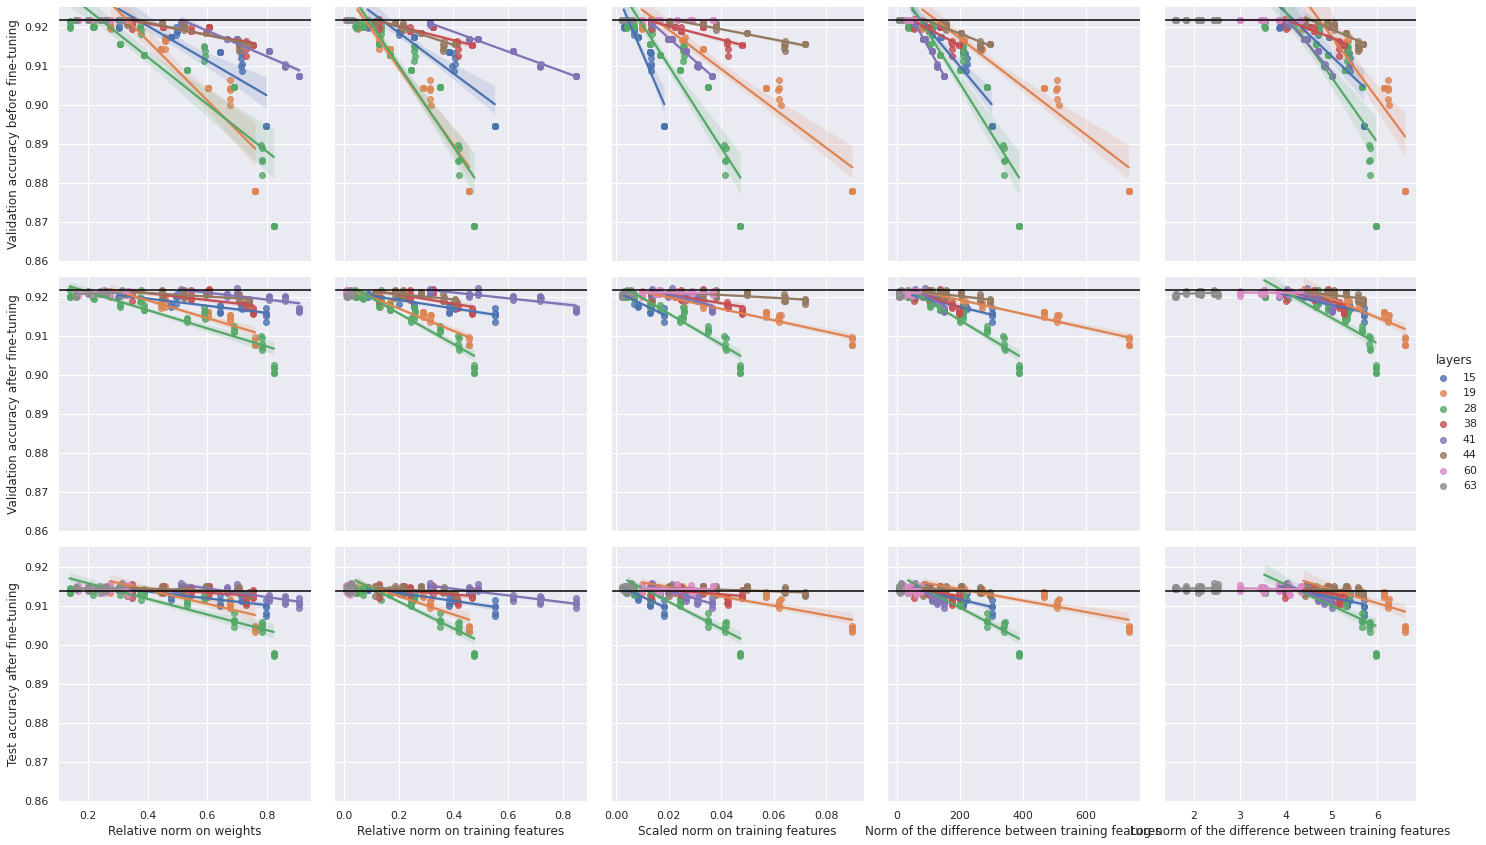

In [177]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm","norm_diff" ,"log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(sns.regplot) # color=".3")
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

g.savefig("../../plots/cifar10/rn18/rn18_c10_linear_errors_performances_layers")

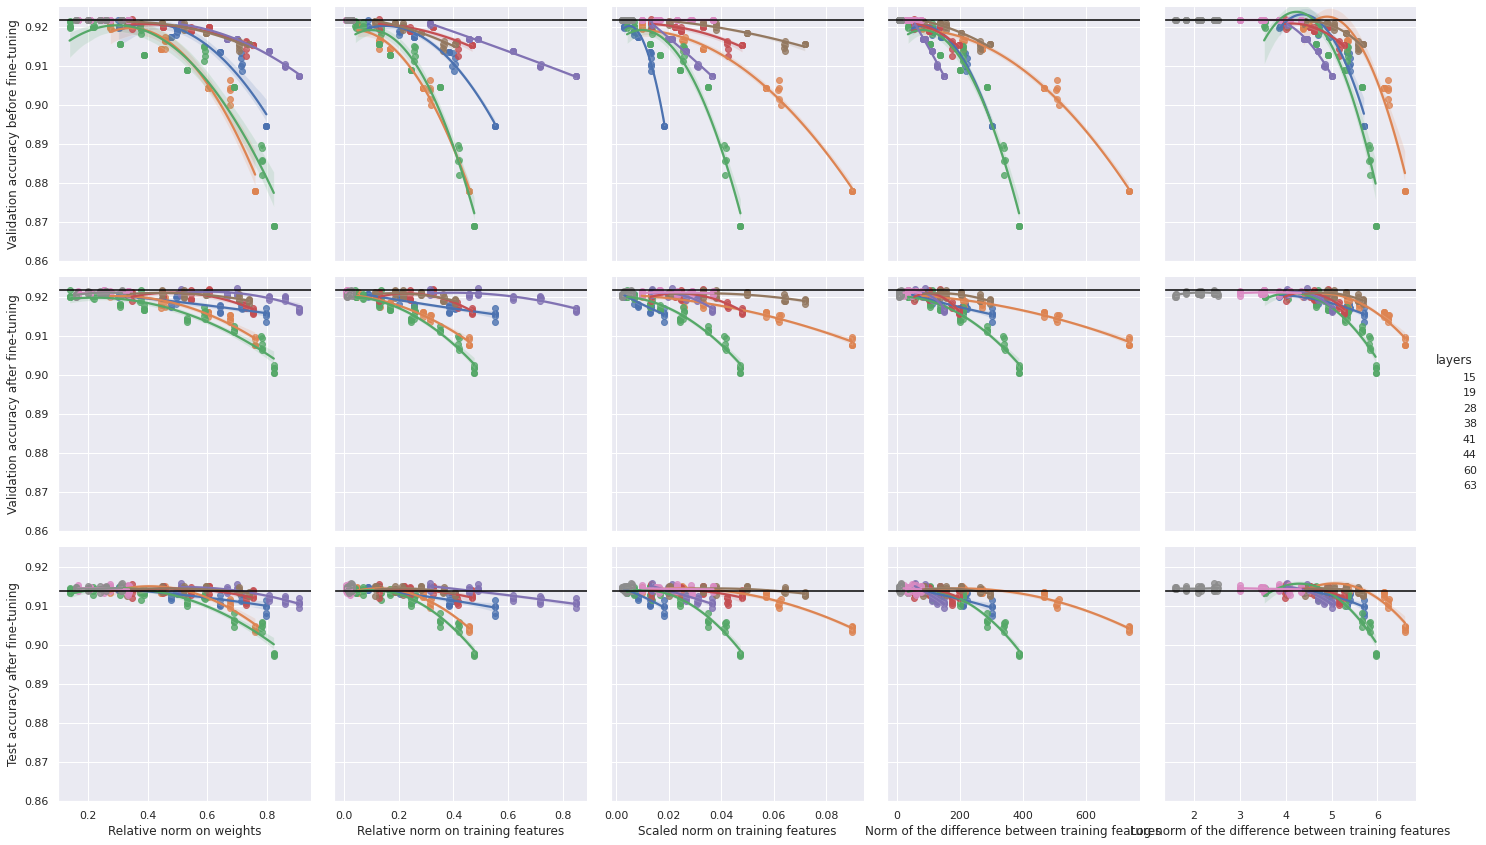

In [178]:
g = sns.PairGrid(
    df,
    y_vars=["valid_acc_before_ft", "valid_acc","test_acc"], 
    x_vars=["error", "relative_norm", "scaled_norm" ,"norm_diff","log_norm_diff"],
    hue="layers",
    height=4,
    # style="factorization",
) #, height=4)
g.map(lambda x, y, **kwargs: sns.regplot(x=x,y=y,order=2)) # sns.scatterplot(x=x,y=y,hue=df.layers,style=df.factorization,legend='auto')
g.set(ylim=(0.86,0.925))
# g.set(ylim=(-1, 11), yticks=[0, 5, 10])
g.add_legend()

lines = {
    0: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    1: {
        "y":baseline_result['best_valid_acc'],
        "color":'black',
    },
    2: {
        "y":baseline_result['test_acc'],
        "color":'black',
    },
}

for i in range(3):
    for j in range(5):
        gax = g.axes[i][j]
        gax.axhline(**(lines[i]))
        xlabel = gax.get_xlabel()
        ylabel = gax.get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])

# plt.legend(
#     bbox_to_anchor=(1.05, 1,1,1),
#     loc='upper left', borderaxespad=0.
# )
g.savefig("../../plots/cifar10/rn18/rn18_c10_poly2_errors_performances_layers")

In [176]:
from statsmodels.api import OLS

errors = ['error', 'relative_norm','scaled_norm','norm_diff']
metrics = ['valid_acc_before_ft','valid_acc','test_acc']

df_ols = pd.DataFrame(index=metrics, columns=errors)

for error in errors:
    for metric in metrics:
        res = OLS(df[metric], df[error], hasconst=True).fit()
        print(res.summary())
        # df_kt[error][metric] = (corr, p)

                             OLS Regression Results                            
Dep. Variable:     valid_acc_before_ft   R-squared:                   -1149.942
Model:                             OLS   Adj. R-squared:              -1149.942
Method:                  Least Squares   F-statistic:                       nan
Date:                 Thu, 24 Mar 2022   Prob (F-statistic):                nan
Time:                         14:15:12   Log-Likelihood:                -109.90
No. Observations:                  260   AIC:                             221.8
Df Residuals:                      259   BIC:                             225.4
Df Model:                            0                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
error          1.5496      0.043     36.46

In [101]:



df_pr_layers = pd.DataFrame(
    index=layers,
    columns=errors_metrics,
)

for layer in df.layers.unique():
    df_layer = df[df.layers==layer]
    for error in errors:
        for metric in metrics:
            corr, p = pearsonr(df_layer[error], df_layer[metric])
            df_pr_layers[f'{error}-{metric}'][str(layer)] = (corr, p)

/home/jetzeschuurman/gitProjects/phd/tddl/venv/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [102]:
df_pr_layers

,error-valid_acc_before_ft,error-valid_acc,error-test_acc,relative_norm-valid_acc_before_ft,relative_norm-valid_acc,relative_norm-test_acc,scaled_norm-valid_acc_before_ft,scaled_norm-valid_acc,scaled_norm-test_acc,norm_diff-valid_acc_before_ft,norm_diff-valid_acc,norm_diff-test_acc
63,"(nan, nan)","(0.2879151138321128, 0.12286811404521604)","(0.08140949047449081, 0.6688969781722545)","(nan, nan)","(0.22660045854936292, 0.2285339296372333)","(0.08969793863827741, 0.6373750749423998)","(nan, nan)","(0.22549585148419915, 0.23087130977122738)","(0.08987146559723141, 0.6367214748520443)","(nan, nan)","(0.22549585148419915, 0.23087130977122738)","(0.08987146559723141, 0.6367214748520443)"
60,"(nan, nan)","(0.05364974643058675, 0.7782745727113813)","(-0.202319015036619, 0.28363153595318413)","(nan, nan)","(-0.07591620160216175, 0.6901010135920719)","(-0.13347274372940285, 0.481960786929708)","(nan, nan)","(-0.07619222745748086, 0.6890298881252326)","(-0.1332129890742588, 0.4828216177381716)","(nan, nan)","(-0.07619222745748086, 0.6890298881252326)","(-0.1332129890742588, 0.4828216177381716)"
28,"(-0.8473943846363547, 8.526029318429482e-15)","(-0.89963258051531, 6.749407186012029e-19)","(-0.8503506557583609, 5.521851294743111e-15)","(-0.9120220389779395, 3.2969719058788e-20)","(-0.9501238765400875, 6.183917885757045e-26)","(-0.9094785965290709, 6.345321235786794e-20)","(-0.9120504145735633, 3.272613774020444e-20)","(-0.9501462603759921, 6.119201642748657e-26)","(-0.9095089557688517, 6.296645262386004e-20)","(-0.9120504145735633, 3.272613774020444e-20)","(-0.9501462603759921, 6.119201642748657e-26)","(-0.9095089557688517, 6.296645262386004e-20)"
44,"(-0.92807967008753, 1.5569321880360468e-13)","(-0.6504162560386235, 9.984548200024738e-05)","(-0.40001403206557967, 0.028506973055201903)","(-0.9426384838741954, 7.18649942865184e-15)","(-0.6841285370782828, 3.0657713149688406e-05)","(-0.43789598452890244, 0.015512948579349773)","(-0.9426349991137994, 7.192458046807915e-15)","(-0.684144129964898, 3.0639890645477375e-05)","(-0.4379219058215649, 0.015506136280367542)","(-0.9426349991137994, 7.192458046807915e-15)","(-0.684144129964898, 3.0639890645477375e-05)","(-0.4379219058215649, 0.015506136280367542)"
15,"(-0.8452560604640299, 4.1808353690622275e-09)","(-0.8308757372821841, 1.3206059307718488e-08)","(-0.778557370077811, 4.0628161410152266e-07)","(-0.9041877267765982, 7.42816655433022e-12)","(-0.88880481257465, 5.416616492454828e-11)","(-0.8428099291664479, 5.125140529275926e-09)","(-0.9042329237813166, 7.381372629649023e-12)","(-0.8888088544663618, 5.414000236015289e-11)","(-0.8428153045877268, 5.122866793629805e-09)","(-0.9042329237813166, 7.381372629649023e-12)","(-0.8888088544663618, 5.414000236015289e-11)","(-0.8428153045877268, 5.122866793629805e-09)"
38,"(-0.865389039933643, 6.767629125830957e-10)","(-0.6776279241263408, 3.895111656379433e-05)","(-0.5044203224748514, 0.004476991652362888)","(-0.8635795042211782, 8.064108376976551e-10)","(-0.7167802034754958, 8.35639365741935e-06)","(-0.48123306693167356, 0.007096860612639137)","(-0.8635896750238307, 8.056224123315002e-10)","(-0.7167965316315917, 8.350594812939163e-06)","(-0.48124877796815807, 0.007094720012967866)","(-0.8635896750238307, 8.056224123315002e-10)","(-0.7167965316315917, 8.350594812939163e-06)","(-0.48124877796815807, 0.007094720012967866)"
41,"(-0.9703158826938701, 8.423955171813325e-19)","(-0.7495675516016722, 1.8693704254260377e-06)","(-0.8643378889684963, 7.495257969083912e-10)","(-0.9941407242821838, 1.3281946044565624e-28)","(-0.8424403179898148, 5.283717911651034e-09)","(-0.885164202369319, 8.308319981602859e-11)","(-0.9941311159924484, 1.3589347640551856e-28)","(-0.8424757709014247, 5.2683145963633854e-09)","(-0.8851908100070819, 8.282817723520555e-11)","(-0.9941311159924484, 1.3589347640551856e-28)","(-0.8424757709014247, 5.2683145963633854e-09)","(-0.8851908100070819, 8.282817723520555e-11)"
19,"(-0.8860065078609245, 7.535093163088947e-11)","(-0.91120302739687